# Gradient boosting method for estimating trigger efficiency - v2.2

## The Procedure

Signal triggers (the final trigger condition is `OR` of all of these):

- HLT_AK8PFHT800_TrimMass50
- HLT_AK8PFJet400_TrimMass30
- HLT_AK8PFJet500
- HLT_PFJet500
- HLT_PFHT1050
- HLT_PFHT500_PFMET100_PFMHT100_IDTight
- HLT_PFHT700_PHMET85_PFMHT85_IDTight
- HLT_PFHT800_PFMET75_PFMHT75_IDTight
- HLT_DoubleMediumChargedIsoPFTauHPS35_Trk1_eta2p1_Reg
- HLT_MediumChargedIsoPFTau180HighPtRelaxedIso_Trk50_eta2p1

Possible reference triggers:

- HLT_IsoMu24 or HLT_Mu50
- HLT_Ele32_WPTight_Gsf or HLT_Ele115_CaloldVT_GsfTrkldT
- HLT_Photon200
- HLT_Ele32_WPTight_Gsf or HLT_Ele115_CaloldVT_GsfTrkldT or HLT_Photon200
- HLT_AK8PFJet260

<aside>

**NB! Suggest to do this gradually, e.g. 2D (FatJet[0], HT); then 3D (adding MET), then… 7D?**

1. Make comparison plots of variables of interest for different samples.
2. Choice of the reference trigger: Compare simulated effciencies and the “measured” efficiencies for the QCD, VBF, and ggF samples, with the different possible reference triggers → choose reference trigger that gives the best agreement across all variables of interest.
3. “Closure test” for the MVA method with MC (use e.g. QCD MC samples)
    1. Measure trigger efficiency in MC using the best reference trigger.
    2. Train MVA using part of the MC sample, pretending that it’s real data: use only events passing the reference trigger, and either passing or failing the signal trigger.
    3. Run the validation plots, using all MC samples:
        - 1D and “2D”/binned-1D plots as a function of the variables of interest:
            - Trigger efficiency (using the average of MVA weights as the per-bin efficiency).
            - Distributions of events passing the trigger, MVA-weighted vs. directly selected.
        - In these plots, overlay:
            - MC-predicted efficiency = “real” efficiency.
            - Prediction with measured efficiency (from 3.1.).
            - MVA efficiency (from MC trained MVA)
        
        → If the method works, all these are supposed to agree.
        
4. The real deal: use the MVA method to estimate the efficiency in DATA
    1. Measure trigger efficiency in DATA using the best reference trigger.
    2. Train MVa using part of the DATA sample: use events passing the reference trigger, and either passing or failing the signal trigger.
    3. Run the validation plots, using both data and each MC sample separately (QCD, VBF, ggF):
        - 1D and “2D”/binned-1D plots as a function of the variables of interest:
            - Trigger efficiency (using the average of MVA weigths as the per-bin efficiency).
            - Distributions of events passing the trigger, MVA-weighted vs. directly selected.
        - In these plots, overlay:
            - (MC-predicted efficiency).
            - Prediction with measured efficiency (from 4.1.).
            - MVA prediction.
        
        → The two latter should agree, while the “MC-only” prediction is NOT expected to agree anymore.
        
</aside>


## $\downarrow$ Tuning everything here

In [1]:
# Define the run name for the analysis
run_name = "Run2"
version = "v2"

# Define the sample we use
samples = ["QCD", "ggF", "VBF", "DATA"]

# Determine to save models
save_model_gradu = False
save_model_data  = False

## Tuning triggers list

In [2]:
# --- 0. Configuration ---
signal_triggers = [
    "HLT_AK8PFHT800_TrimMass50",
    "HLT_AK8PFJet400_TrimMass30",
    "HLT_AK8PFJet500",
    "HLT_PFJet500",
    "HLT_PFHT1050",
    "HLT_PFHT500_PFMET100_PFMHT100_IDTight",
    "HLT_PFHT700_PFMET85_PFMHT85_IDTight",
    "HLT_PFHT800_PFMET75_PFMHT75_IDTight",
    "HLT_DoubleMediumChargedIsoPFTauHPS35_Trk1_eta2p1_Reg",
    "HLT_MediumChargedIsoPFTau180HighPtRelaxedIso_Trk50_eta2p1"
]

signal_trigger = "Combo"

reference_triggers = ["HLT_AK8PFJet260"]

reference_trigger = reference_triggers[0]

filter_pass_real = signal_trigger

filter_pass_meas = signal_trigger + "&&" + reference_trigger

filter_all_meas = reference_trigger

all_columns      = ["HighestPt", "HT", "MET_pt", "mHH","HighestMass", "SecondHighestPt", 
                    "SecondHighestMass", "FatHT", "MET_FatJet", "mHHwithMET", "HighestEta", 
                    "SecondHighestEta", "DeltaEta", "DeltaPhi", 
                    # "nJet_pt30", "maxFatJetMass", "FatJetBalance", "minDeltaPhiJetMET", "TauPt1st", "TauPt2nd",
                    "Combo", reference_trigger]

samples = ["QCD", "ggF", "VBF", "DATA"]

## Libraries

In [ ]:
import os, time
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import ROOT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from library.trigger_efficiency_ML import *
from IPython.display import display

## Step 1: Preparing Data

In [ ]:
# --- 1. Loading Data ---
print(f"Data version {version}")
if version == "v1":
    suffix = "briar"
elif version == "v2":
    suffix = "azura"
elif version == "v3":
    suffix = "ashe"
elif version == "v4":
    suffix = "cypress"
elif version == "v5":
    suffix = "azura-v2"
elif version == "v6":
    suffix = "newQCD"
elif version == "v7":
    suffix = "oldQCD"

datapath  = f"data/processed/{suffix}/"

# Load data
df_QCD = ROOT.RDataFrame(f"{suffix}-NewQCD", datapath + f"{suffix}-NewQCD.root")
df_ggF = ROOT.RDataFrame(f"{suffix}-NewggF", datapath + f"{suffix}-NewggF.root")
df_VBF = ROOT.RDataFrame(f"{suffix}-NewVBF", datapath + f"{suffix}-NewVBF.root")
df_DATA = ROOT.RDataFrame(f"{suffix}-NewDATA", datapath + f"{suffix}-NewDATA.root")
data = [df_QCD, df_ggF, df_VBF, df_DATA]

# Load models
filename_gradu = f'model/{suffix}/gb_{suffix}_200et0p2_gradu.sav'
filename_data  = f'model/{suffix}/gb_{suffix}_200et0p2_data.sav'

suffix = "-thesis-v2"

Data version v2


## Step 2: Data Distribution

In [5]:
# Create lists for distributions of events passing the signal trigger and all events in the simulation samples

variable_list, names_list, names_list_and_signal_trigger, names_list_plot, range_min_list, range_max_list, num_bins_list, y_min_list, y_max_list = define_parameter("dist")

num_QCD_list = []
denom_QCD_list = []
num_ggF_list = []
denom_ggF_list = []
num_VBF_list = []
denom_VBF_list = []
all_nums_and_denoms = []

y_range_list = [1000 for t in range(len(variable_list))]

for j in range(len(range_min_list)):
    num_QCD, denom_QCD = numerator_and_denominator(df_QCD, "QCD", filter_pass_real, filter_pass_meas, filter_all_meas, variable_list[j], names_list[j], names_list_plot[j], y_range_list[j], run_name, suffix)
    num_QCD_list.append(num_QCD)
    denom_QCD_list.append(denom_QCD)

    num_ggF, denom_ggF = numerator_and_denominator(df_ggF, "ggF", filter_pass_real, filter_pass_meas, filter_all_meas, variable_list[j], names_list[j], names_list_plot[j], y_range_list[j], run_name, suffix)
    num_ggF_list.append(num_ggF)
    denom_ggF_list.append(denom_ggF)

    num_VBF, denom_VBF = numerator_and_denominator(df_VBF, "VBF", filter_pass_real, filter_pass_meas, filter_all_meas, variable_list[j], names_list[j], names_list_plot[j], y_range_list[j], run_name, suffix)
    num_VBF_list.append(num_VBF)
    denom_VBF_list.append(denom_VBF)

    # Combine all nums and denoms for this iteration into a single list and append to all_numsa_and_denoms
    combined_list = [num_QCD, denom_QCD, num_ggF, denom_ggF, num_VBF, denom_VBF]
    all_nums_and_denoms.append(combined_list)

Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/QCD_HighestPt_Run2_both.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/ggF_HighestPt_Run2_both.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/VBF_HighestPt_Run2_both.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/QCD_HT_Run2_both.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/ggF_HT_Run2_both.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/pr

In [6]:
# Distributions of all the simulation samples in the same plot
# variable_list, names_list, names_list_and_signal_trigger, names_list_plot, range_min_list, range_max_list, num_bins_list, y_min_list, y_max_list = define_parameter("dist")

y_range_list = [1100, 1200, 2700, 2500, 10000, 1300, 5400, 1200, 2700, 2300, 20000, 25000, 17000, 12000] #, 10, 10, 10, 10, 10, 10]

color_list   = [ROOT.kViolet, ROOT.kAzure-5, ROOT.kRed+1, ROOT.kOrange+2, ROOT.kGray+3, ROOT.kGreen+2]

legend_list  = ["#splitline{QCD events passing the}{signal trigger}", "QCD all events", "#splitline{ggF events passing the}{signal trigger}",
               "ggF all events", "#splitline{VBF events passing the}{signal trigger}", "VBF all events"]

for i in range(len(num_QCD_list)):
    draw_histograms_same(all_nums_and_denoms[i], color_list, y_range_list[i], legend_list, names_list_plot[i], "Events", "Distribution_MC_" + names_list[i] + ".png", "QCD", suffix)

Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/Distribution_MC_HighestPt.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/Distribution_MC_HT.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/Distribution_MC_MET_pt.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/Distribution_MC_mHH.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/Distribution_MC_HighestMass.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern

In [7]:
# Distributions of event passing the reference trigger and signal and reference trigger for the data sample
y_range_list = [700, 600, 2300, 1300, 6000, 800, 4100, 600, 1600, 1200, 7000, 7000, 5000, 9000] #, 10, 10, 10, 10, 10, 10]
num_DATA_list   = []
denom_DATA_list = []

for j in range(len(range_min_list)):
    num_DATA, denom_DATA = numerator_and_denominator(df_DATA, "DATA", filter_pass_real, filter_pass_meas, filter_all_meas, variable_list[j], names_list[j], names_list_plot[j], y_range_list[j], run_name, suffix)
    num_DATA_list.append(num_DATA)
    denom_DATA_list.append(denom_DATA)

Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/DATA_HighestPt_Run2_both.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/DATA_HT_Run2_both.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/DATA_MET_pt_Run2_both.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/DATA_mHH_Run2_both.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/DATA_HighestMass_Run2_both.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-sour

## Step 3: Choosing Reference Trigger (Efficiencies Plots)

In [8]:
eff_real_list = []
eff_meas_list = []
for i in range(len(samples)):
    variable_list, names_list, names_list_and_signal_trigger, names_list_plot, range_min_list, range_max_list, num_bins_list, y_min_list, y_max_list = define_parameter(samples[i])
    if samples[i] != "DATA":
        eff_real, eff_meas = choosing_reference_trigger(samples[i], data[i], variable_list, names_list, names_list_plot, range_min_list, range_max_list, num_bins_list, y_min_list, y_max_list, signal_trigger, reference_trigger, run_name, suffix)
        eff_real_list.append(eff_real)
        eff_meas_list.append(eff_meas)
    else:
        eff_list_DATA = choosing_reference_trigger(samples[i], data[i], variable_list, names_list, names_list_plot, range_min_list, range_max_list, num_bins_list, y_min_list, y_max_list, signal_trigger, reference_trigger, run_name, suffix)



Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/QCD_TEfficiency_HighestPt_HLT_AK8PFJet260_Run2.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/QCD_TEfficiency_HT_HLT_AK8PFJet260_Run2.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/QCD_TEfficiency_MET_pt_HLT_AK8PFJet260_Run2.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/QCD_TEfficiency_mHH_HLT_AK8PFJet260_Run2.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/QCD_TEfficiency_HighestMass_HLT_AK

## Step 4: Training Gradient-Boosting Algorithm

Iteration 1 - Validation Accuracy: 0.9112
Iteration 2 - Validation Accuracy: 0.9117
Iteration 3 - Validation Accuracy: 0.9059
Iteration 4 - Validation Accuracy: 0.9116
Iteration 5 - Validation Accuracy: 0.9076
Iteration 6 - Validation Accuracy: 0.9114
Iteration 7 - Validation Accuracy: 0.9150
Iteration 8 - Validation Accuracy: 0.9150
Iteration 9 - Validation Accuracy: 0.9124
Iteration 10 - Validation Accuracy: 0.9064
Iteration 11 - Validation Accuracy: 0.9091
Iteration 12 - Validation Accuracy: 0.9108
Iteration 13 - Validation Accuracy: 0.9091
Iteration 14 - Validation Accuracy: 0.9119
Iteration 15 - Validation Accuracy: 0.9124
Iteration 16 - Validation Accuracy: 0.9178
Iteration 17 - Validation Accuracy: 0.9121
Iteration 18 - Validation Accuracy: 0.9083
Iteration 19 - Validation Accuracy: 0.9129
Iteration 20 - Validation Accuracy: 0.9106
Model 1 - Test Accuracy: 0.9116
Model 2 - Test Accuracy: 0.9120
Model 3 - Test Accuracy: 0.9088
Model 4 - Test Accuracy: 0.9140
Model 5 - Test Accura

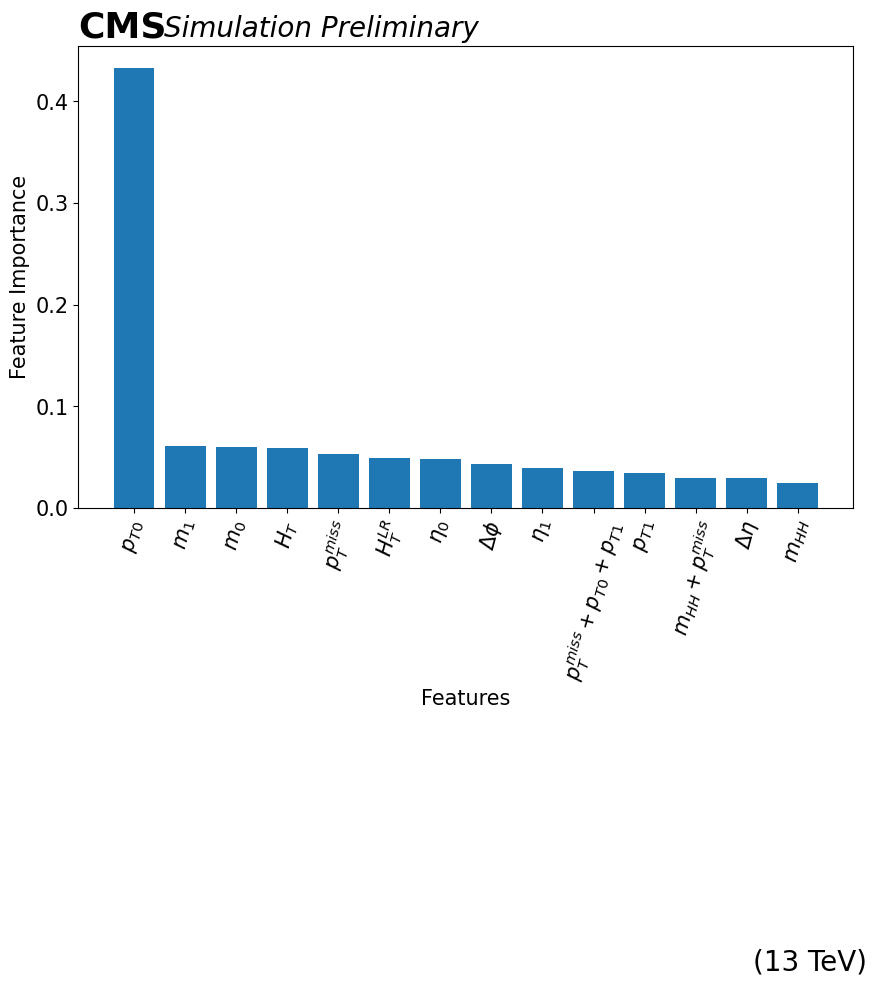

In [9]:
# Developing the Method Using Simulated Sample
variable_list, names_list, names_list_and_signal_trigger, names_list_plot, range_min_list, range_max_list, num_bins_list, y_min_list, y_max_list = define_parameter("QCD")
model_gradu = train_method(df_QCD, names_list_and_signal_trigger, names_list, n_estimators=200, learning_rate=0.2, depth=11, random_state=42, filter_all_meas=filter_all_meas, n_samples=20)
open_models(filename_gradu, save_model=save_model_gradu, models=model_gradu)
feature_ranking("QCD", df_QCD, model_gradu, filter_all_meas, names_list_and_signal_trigger, names_list, suffix)

Iteration 1 - Validation Accuracy: 0.9072
Iteration 2 - Validation Accuracy: 0.9072
Iteration 3 - Validation Accuracy: 0.9099
Iteration 4 - Validation Accuracy: 0.9031
Iteration 5 - Validation Accuracy: 0.9054
Iteration 6 - Validation Accuracy: 0.9080
Iteration 7 - Validation Accuracy: 0.9097
Iteration 8 - Validation Accuracy: 0.9054
Iteration 9 - Validation Accuracy: 0.9076
Iteration 10 - Validation Accuracy: 0.9052
Iteration 11 - Validation Accuracy: 0.9099
Iteration 12 - Validation Accuracy: 0.9093
Iteration 13 - Validation Accuracy: 0.9051
Iteration 14 - Validation Accuracy: 0.9042
Iteration 15 - Validation Accuracy: 0.9031
Iteration 16 - Validation Accuracy: 0.9079
Iteration 17 - Validation Accuracy: 0.9078
Iteration 18 - Validation Accuracy: 0.9100
Iteration 19 - Validation Accuracy: 0.9116
Iteration 20 - Validation Accuracy: 0.9027
Model 1 - Test Accuracy: 0.9114
Model 2 - Test Accuracy: 0.9049
Model 3 - Test Accuracy: 0.9055
Model 4 - Test Accuracy: 0.9053
Model 5 - Test Accura

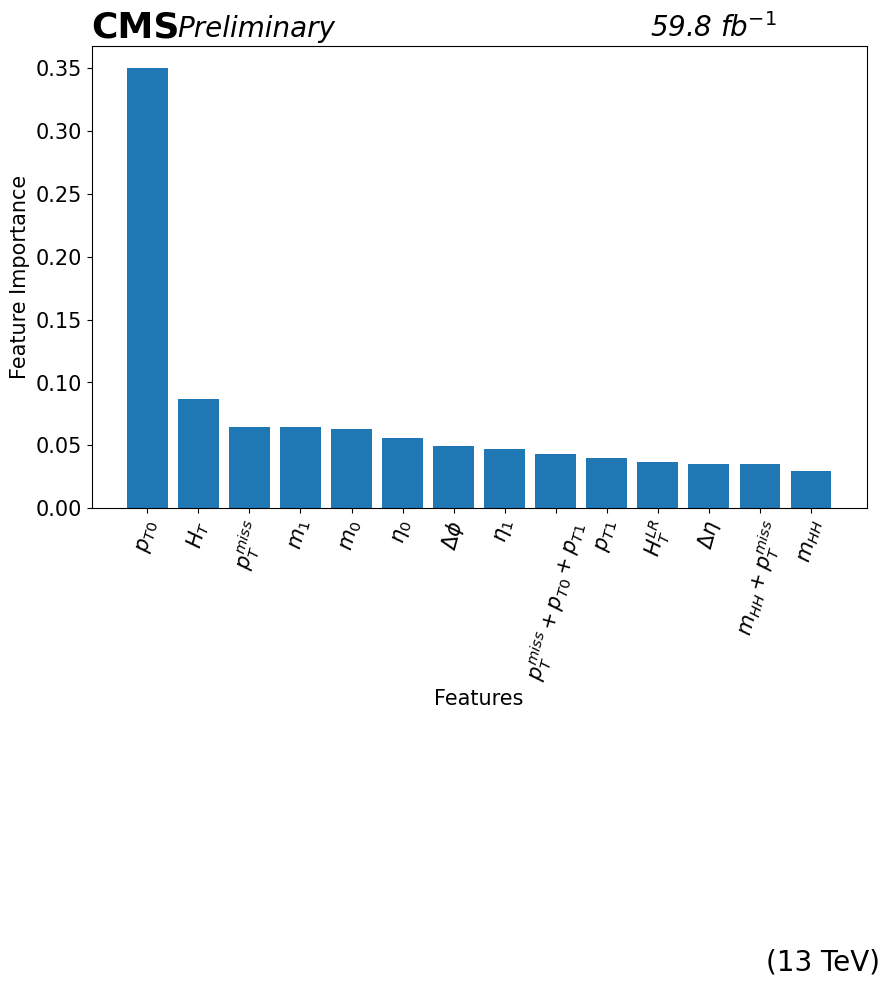

In [10]:
# Developing the Method Using Data
variable_list, names_list, names_list_and_signal_trigger, names_list_plot, range_min_list, range_max_list, num_bins_list, y_min_list, y_max_list = define_parameter("DATA")
model_data = train_method(df_DATA, names_list_and_signal_trigger, names_list, n_estimators=200, learning_rate=0.2, depth=11, random_state=42, filter_all_meas=filter_all_meas, n_samples=20)
open_models(filename_data, save_model=save_model_data, models=model_data)
feature_ranking("DATA", df_DATA, model_data, filter_all_meas, names_list_and_signal_trigger, names_list, suffix)

## Step 5: Applying the Method

In [11]:
mean_fpr_list = {}
mean_tpr_list = {}
avg_test_accuracy_list = {}
avg_auc_score_list = {}

Model 1 - Test Accuracy: 0.9113 - AUC-ROC Score: 0.9451
Model 2 - Test Accuracy: 0.9116 - AUC-ROC Score: 0.9463
Model 3 - Test Accuracy: 0.9119 - AUC-ROC Score: 0.9453
Model 4 - Test Accuracy: 0.9127 - AUC-ROC Score: 0.9462
Model 5 - Test Accuracy: 0.9115 - AUC-ROC Score: 0.9460
Model 6 - Test Accuracy: 0.9130 - AUC-ROC Score: 0.9461
Model 7 - Test Accuracy: 0.9125 - AUC-ROC Score: 0.9469
Model 8 - Test Accuracy: 0.9121 - AUC-ROC Score: 0.9463
Model 9 - Test Accuracy: 0.9124 - AUC-ROC Score: 0.9460
Model 10 - Test Accuracy: 0.9115 - AUC-ROC Score: 0.9449
Model 11 - Test Accuracy: 0.9124 - AUC-ROC Score: 0.9456
Model 12 - Test Accuracy: 0.9126 - AUC-ROC Score: 0.9456
Model 13 - Test Accuracy: 0.9120 - AUC-ROC Score: 0.9456
Model 14 - Test Accuracy: 0.9115 - AUC-ROC Score: 0.9447
Model 15 - Test Accuracy: 0.9125 - AUC-ROC Score: 0.9461
Model 16 - Test Accuracy: 0.9114 - AUC-ROC Score: 0.9461
Model 17 - Test Accuracy: 0.9127 - AUC-ROC Score: 0.9467
Model 18 - Test Accuracy: 0.9121 - AUC-R

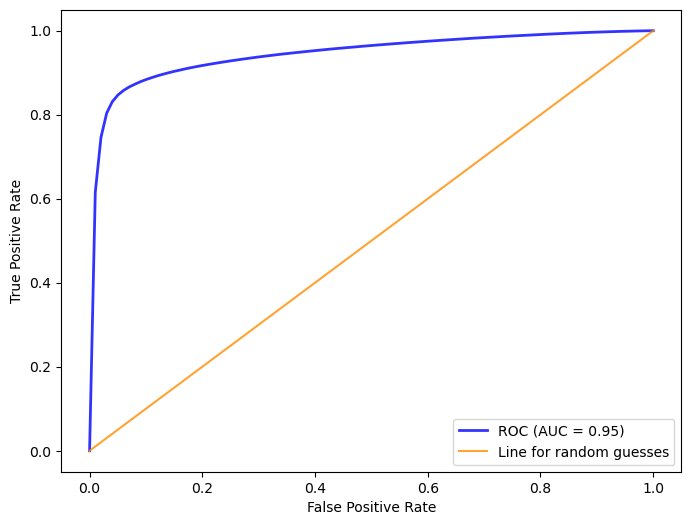

Model 1 - Test Accuracy: 0.6826 - AUC-ROC Score: 0.7899
Model 2 - Test Accuracy: 0.6815 - AUC-ROC Score: 0.7915
Model 3 - Test Accuracy: 0.6743 - AUC-ROC Score: 0.7834
Model 4 - Test Accuracy: 0.6803 - AUC-ROC Score: 0.7974
Model 5 - Test Accuracy: 0.6795 - AUC-ROC Score: 0.7897
Model 6 - Test Accuracy: 0.6802 - AUC-ROC Score: 0.7925
Model 7 - Test Accuracy: 0.6881 - AUC-ROC Score: 0.7890
Model 8 - Test Accuracy: 0.6906 - AUC-ROC Score: 0.7911
Model 9 - Test Accuracy: 0.6843 - AUC-ROC Score: 0.7859
Model 10 - Test Accuracy: 0.6848 - AUC-ROC Score: 0.7897
Model 11 - Test Accuracy: 0.6904 - AUC-ROC Score: 0.7890
Model 12 - Test Accuracy: 0.6730 - AUC-ROC Score: 0.7917
Model 13 - Test Accuracy: 0.6742 - AUC-ROC Score: 0.7894
Model 14 - Test Accuracy: 0.6826 - AUC-ROC Score: 0.7973
Model 15 - Test Accuracy: 0.6721 - AUC-ROC Score: 0.7878
Model 16 - Test Accuracy: 0.6830 - AUC-ROC Score: 0.7928
Model 17 - Test Accuracy: 0.6840 - AUC-ROC Score: 0.7914
Model 18 - Test Accuracy: 0.6904 - AUC-R

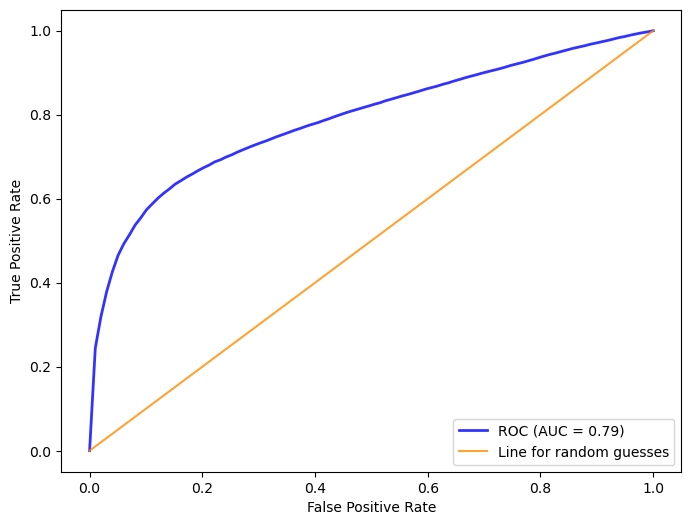

Model 1 - Test Accuracy: 0.8913 - AUC-ROC Score: 0.9217
Model 2 - Test Accuracy: 0.8930 - AUC-ROC Score: 0.9238
Model 3 - Test Accuracy: 0.8890 - AUC-ROC Score: 0.9219
Model 4 - Test Accuracy: 0.8906 - AUC-ROC Score: 0.9227
Model 5 - Test Accuracy: 0.8926 - AUC-ROC Score: 0.9229
Model 6 - Test Accuracy: 0.8674 - AUC-ROC Score: 0.9142
Model 7 - Test Accuracy: 0.8518 - AUC-ROC Score: 0.9052
Model 8 - Test Accuracy: 0.8919 - AUC-ROC Score: 0.9202
Model 9 - Test Accuracy: 0.8931 - AUC-ROC Score: 0.9242
Model 10 - Test Accuracy: 0.8956 - AUC-ROC Score: 0.9221
Model 11 - Test Accuracy: 0.8960 - AUC-ROC Score: 0.9241
Model 12 - Test Accuracy: 0.8554 - AUC-ROC Score: 0.9121
Model 13 - Test Accuracy: 0.8871 - AUC-ROC Score: 0.9214
Model 14 - Test Accuracy: 0.8919 - AUC-ROC Score: 0.9253
Model 15 - Test Accuracy: 0.8840 - AUC-ROC Score: 0.9221
Model 16 - Test Accuracy: 0.8931 - AUC-ROC Score: 0.9246
Model 17 - Test Accuracy: 0.8926 - AUC-ROC Score: 0.9225
Model 18 - Test Accuracy: 0.8946 - AUC-R

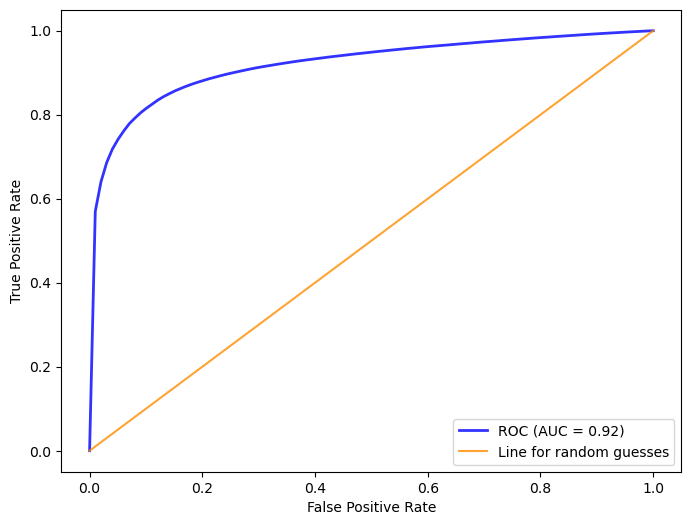

Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/STD_QCD_TEfficiencyHighestPt_GB1_Run2.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/STD_QCD_TEfficiencyHT_GB1_Run2.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/STD_QCD_TEfficiencyMET_pt_GB1_Run2.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/STD_QCD_TEfficiencymHH_GB1_Run2.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/STD_QCD_TEfficiencyHighestMass_GB1_Run2.png has been created
Info in <

In [12]:
# Applying model to MC sample
for i in range(len(samples)):
    if samples[i] != "DATA":
        variable_list, names_list, names_list_and_signal_trigger, names_list_plot, range_min_list, range_max_list, num_bins_list, y_min_list, y_max_list = define_parameter(samples[i])
        mean_list, mean_plus_list, mean_minus_list, avg_test_accuracy, avg_auc_score, mean_fpr, mean_tpr = applying_method(data[i], model_gradu, names_list_and_signal_trigger, names_list, num_bins_list, range_min_list, range_max_list, filter_all_meas, signal_trigger, n_samples=20)
        mean_fpr_list[samples[i]] = mean_fpr
        mean_tpr_list[samples[i]] = mean_tpr
        avg_test_accuracy_list[samples[i]] = avg_test_accuracy
        avg_auc_score_list[samples[i]] = avg_auc_score

        for j in range(0, len(num_bins_list)):
            efficiency_plot_stds(eff_real_list[i][j], eff_meas_list[i][j], mean_list[j],
                                mean_plus_list[j], mean_minus_list[j], None, "True efficiency",
                                "Measured efficiency", "GB mean efficieny", "", "", y_min_list[j],
                                y_max_list[j], range_min_list[j], range_max_list[j], names_list_plot[j],
                                 "STD_" + samples[i] + "_TEfficiency" + names_list[j] + "_GB1_" + run_name + ".png", samples[i], suffix)

Model 1 - Test Accuracy: 0.9074 - AUC-ROC Score: 0.9314
Model 2 - Test Accuracy: 0.9064 - AUC-ROC Score: 0.9306
Model 3 - Test Accuracy: 0.9062 - AUC-ROC Score: 0.9304
Model 4 - Test Accuracy: 0.9081 - AUC-ROC Score: 0.9308
Model 5 - Test Accuracy: 0.9059 - AUC-ROC Score: 0.9297
Model 6 - Test Accuracy: 0.9058 - AUC-ROC Score: 0.9282
Model 7 - Test Accuracy: 0.9053 - AUC-ROC Score: 0.9301
Model 8 - Test Accuracy: 0.9060 - AUC-ROC Score: 0.9296
Model 9 - Test Accuracy: 0.9060 - AUC-ROC Score: 0.9303
Model 10 - Test Accuracy: 0.9064 - AUC-ROC Score: 0.9301
Model 11 - Test Accuracy: 0.9078 - AUC-ROC Score: 0.9318
Model 12 - Test Accuracy: 0.9076 - AUC-ROC Score: 0.9310
Model 13 - Test Accuracy: 0.9060 - AUC-ROC Score: 0.9292
Model 14 - Test Accuracy: 0.9066 - AUC-ROC Score: 0.9303
Model 15 - Test Accuracy: 0.9057 - AUC-ROC Score: 0.9311
Model 16 - Test Accuracy: 0.9057 - AUC-ROC Score: 0.9305
Model 17 - Test Accuracy: 0.9070 - AUC-ROC Score: 0.9312
Model 18 - Test Accuracy: 0.9068 - AUC-R

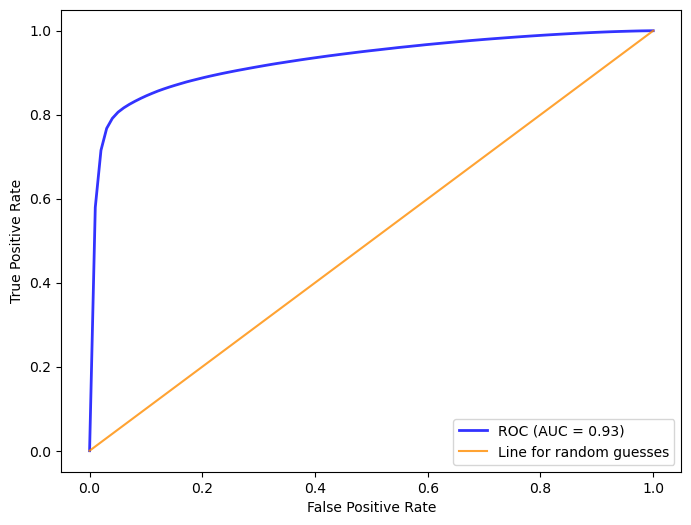

Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/STD_DATA_TEfficiencyHighestPt_GB1_Run2.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/STD_DATA_TEfficiencyHT_GB1_Run2.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/STD_DATA_TEfficiencyMET_pt_GB1_Run2.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/STD_DATA_TEfficiencymHH_GB1_Run2.png has been created
Info in <TCanvas::Print>: png file /Users/khatran/Documents/CERN/cern-source/project/CMS-trigger-efficiency-briar/result/04-09-2025-thesis-v2/STD_DATA_TEfficiencyHighestMass_GB1_Run2.png has been created
Warn

In [13]:
# Applying to data sample
variable_list, names_list, names_list_and_signal_trigger, names_list_plot, range_min_list, range_max_list, num_bins_list, y_min_list, y_max_list = define_parameter("DATA")
mean_list, mean_plus_list, mean_minus_list, avg_test_accuracy, avg_auc_score, mean_fpr, mean_tpr = applying_method(df_DATA, model_data, names_list_and_signal_trigger, names_list, num_bins_list, range_min_list, range_max_list, filter_all_meas, signal_trigger, n_samples=20)
mean_fpr_list["DATA"] = mean_fpr
mean_tpr_list["DATA"] = mean_tpr
avg_test_accuracy_list["DATA"] = avg_test_accuracy
avg_auc_score_list["DATA"] = avg_auc_score

for j in range(0, len(num_bins_list)):
            efficiency_plot_stds(eff_list_DATA[j], None, mean_list[j],
                                mean_plus_list[j], mean_minus_list[j], None, "True efficiency",
                                "Measured efficiency", "GB mean efficieny", "", "", y_min_list[j],
                                y_max_list[j], range_min_list[j], range_max_list[j], names_list_plot[j],
                                 "STD_" + "DATA" + "_TEfficiency" + names_list[j] + "_GB1_" + run_name + ".png", "DATA", suffix)

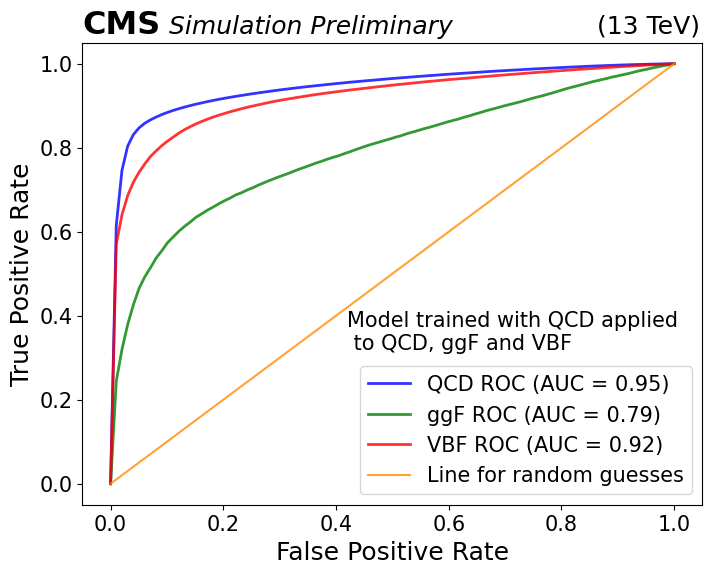

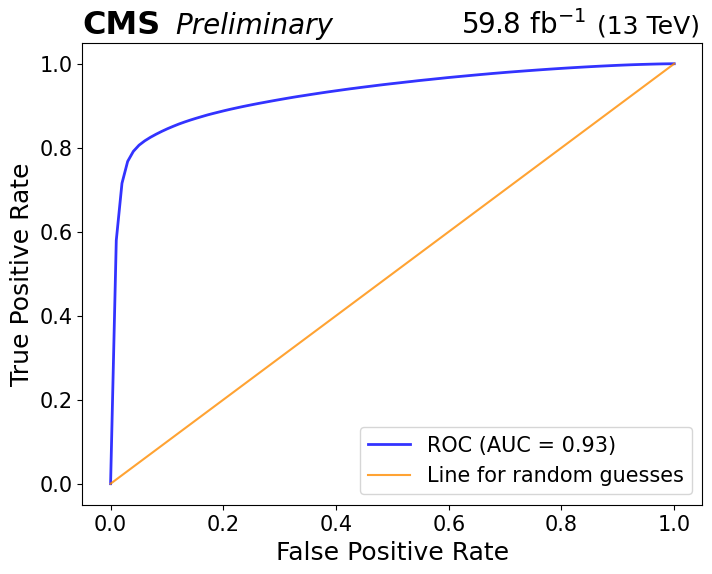

In [14]:
ROC_curve_plotting("QCD", mean_fpr_list, mean_tpr_list, avg_auc_score_list, suffix)
ROC_curve_plotting("DATA", mean_fpr_list, mean_tpr_list, avg_auc_score_list, suffix)